Abstand Szintillator mitt 208mm vv

Na22cal mu1 639.03 sigma1 15.72 mu2 1663.50 sigma 25.21

In [21]:
import uncertainties.unumpy as unp
import uncertainties as u
from uncertainties.umath import log


from uncertainties import ufloat
import numpy as np
import pandas as pd
import scipy as sp
import kafe2
import matplotlib.pyplot as plt
import os
import glob
import struct
import sympy

from pathlib import Path
from tools import *



In [22]:

directory =  Path().resolve()/Path("data")

file_list = [x for x in sorted(glob.glob(os.path.join(directory, '*.txt')), key=os.path.getmtime, reverse=True) if ("Peaks" in x)]
compton_files = [x for x in sorted(glob.glob(os.path.join(directory, '*.dat')), key=os.path.getmtime, reverse=True) if "target" in x]

all_files = sorted(glob.glob(os.path.join(directory, '*.dat')), key=os.path.getmtime, reverse=True)
print(compton_files)

['C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target85.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target85.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target70.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target70.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target55.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target 55.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target40.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target25.dat']


In [23]:
# for file in all_files:
#     title = (file.split("\\"))[-1].split(".")[0]
#     if len(title)>6:
#         dxList1,tList1,nevent1= dat_extract(file)
#         plt.title(title)
#         plot_hist(dxList1,nevent1)
#         plt.show()

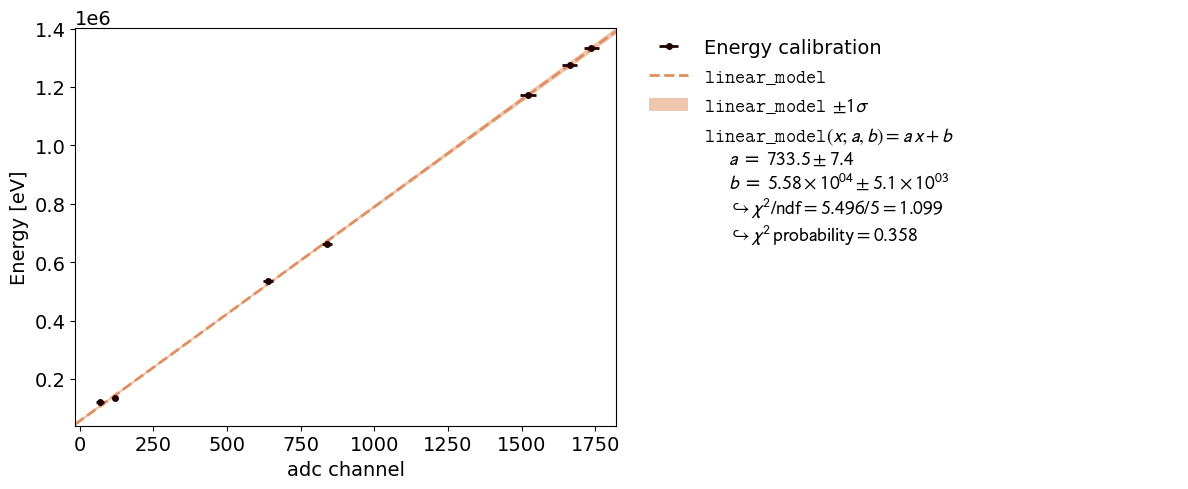

In [24]:
### Energy calibration ###

photo_channel=np.array([[640.4566927820908, 17.0401414090759, 2.834-1.275-2*510998*1e-6], [ 1663.4977923728798, 25.21176031341638 , 1.275], # Na22
                        [839.2925784848783, 17.06645531075148 , 0.662], #Cs137
                        [1520.768861718434, 27.723866249761517, 2.505 - 1.332], [1736.0718592449252, 25.399024362484912 , 1.332],  #Co60
                        [68.47946799509003, 12.832700250520432, 0.136-0.0144], [118.28899175517358, 7.775908633336143, 0.136]]) #Co57


data = kafe2.XYContainer(photo_channel[:,0],photo_channel[:,2]*1e6)
data.label = 'Energy calibration'
data.add_error('x', photo_channel[:,1])

fit = kafe2.Fit(data)
fit.do_fit()
pl = kafe2.Plot(fit)
pl.x_label = 'adc channel'
pl.y_label = 'Energy [eV]' 
#pl.x_range = (0.0014, 0.0019)

pl.plot()
plt.show()

def convertChannel(channel,error=False):
    """
    converts the channel number into the corresponding Energy in eV
    Args:
        channel: int channel of the adc

    Returns:
        float: Energy value
    """
    global fit
    if error:
        return (u.ufloat(fit.parameter_values[0], fit.parameter_errors[0])*channel+u.ufloat(fit.parameter_values[1], fit.parameter_errors[1]))*1e-6
    return (fit.parameter_values[0]*channel+fit.parameter_values[1])*1e-6


gamma flux is $\phi_{det}=A_\gamma\frac{1}{4 \pi l^2}$ with $A_\gamma=A_0 e^{-ln(2) \frac{t_{passed}}{t_{1/2}}}$

$R_\gamma=\phi_{det} \pi r^2$
$\epsilon = \frac{4N l^2}{t_{meas} A_0   r^2}e^{ln(2) \frac{t_{passed}}{t_{1/2}}}$ 
efficiency

Efficiency for  0.6711618875287867 MeV: 0.05431676985960265


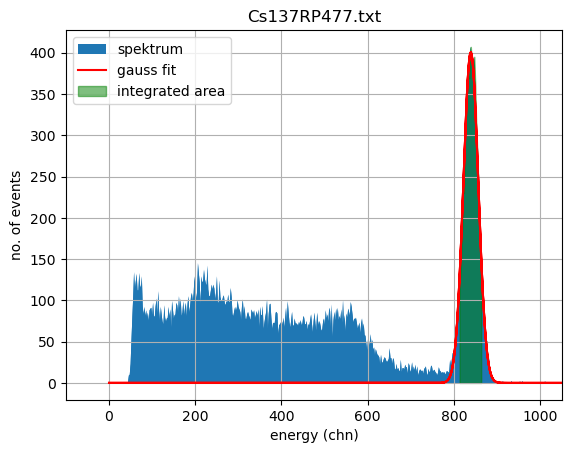

offset
Efficiency for  0.5224949523521859 MeV: 0.1034875432823932
Efficiency for  1.270577705142108 MeV: 0.028455801295248506


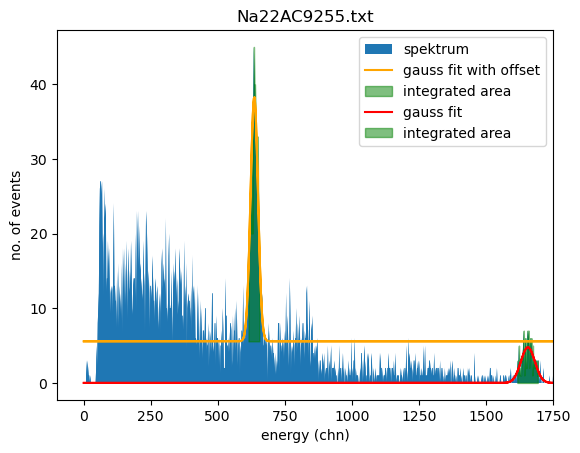

offset
Efficiency for  1.169665543213466 MeV: 0.0066948730228987025
Efficiency for  1.3256989896935916 MeV: 0.006301712105425838


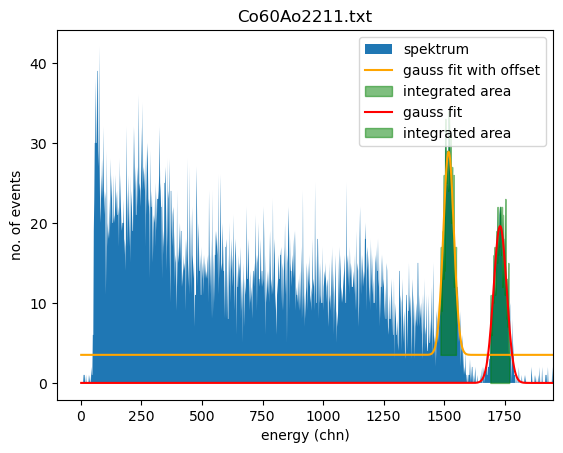

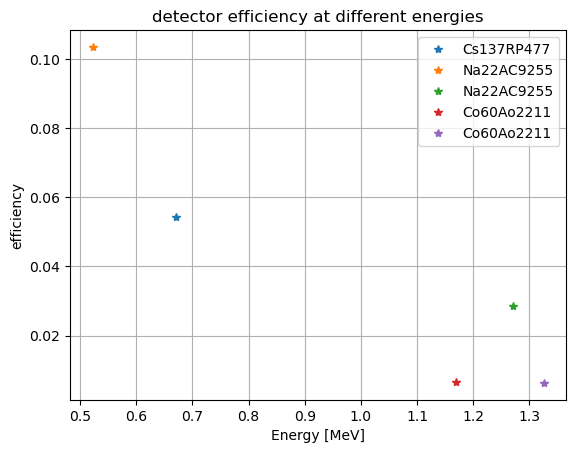

In [25]:


# dxList1,tList1,nevent1= dat_extract(directory/file)
# n1, bins, patches1 = plt.hist(dxList1, nBins, range=(0,nBins*binSize))

# bin_centers = bins[:-1] + binSize/2

# x1,y1=gauss_fit(bin_centers,n1,1600,1800,0)
# x,y,z=gauss_fit( bin_centers,n1,1400,1600,5)

# peak1=integrate(bin_centers,n1,x1,y1)
# peak2=integrate(bin_centers,n1,x,y,z)

# plt.show()


from tools import *
files=[ 
    #[Path("Co57.txt"), [[20,80,0], [100,200,0]], [300, 300, 0.744, 4]], 
       [Path("Cs137RP477.txt"), [[750,1000,0]], [300, 1.22e5,  30.2, 23/365]],
       [Path("Na22AC9255.txt"), [[500,700,10],[1500,1700,0]], [300, 4.28e3, 2.6, 23/365]], 
       [Path("Co60Ao2211.txt"), [[1400,1700,10],[1700,1900,0]] , [600, 4.01e4, 5.27, 23/365]]]
file=Path("Co60Ao2211.dat")
binSize=2
nBins=1000

def efficiency(N, t, A_0,t_2, t_sample):
    l=0.208
    r=0.0255
    return (4*N*l**2)*np.exp(np.log(2)*t_sample/t_2)/(t*A_0*r**2)

eff_pairs=[]
for file, lists, dat in files:
    bin_centers,n1 = getfromtxt(directory/file)

    plt.fill_between(bin_centers, n1,label="spektrum")
    try:
        for list in lists:
            x,y,z=gauss_fit(bin_centers,n1,list[0],list[1],list[2])
            peak=integrate(bin_centers,n1,x,y,z)
            print("Efficiency for ",convertChannel(x),"MeV:",efficiency(peak, dat[0], dat[1], dat[2], dat[3]))
            eff_pairs.append([convertChannel(x),efficiency(peak, dat[0], dat[1], dat[2], dat[3]), (str(file).split(".") )[0]])

    except Exception as  e:
        print(e)
    plt.title(str(file))
    plt.xlim(right=list[1]+50)
    plt.legend()
    plt.show();
for pair in eff_pairs:
    plt.plot(pair[0],pair[1],"*",label=pair[2])
plt.title("detector efficiency at different energies")
plt.xlabel("Energy [MeV]")
plt.ylabel("efficiency")
plt.legend()
plt.grid(1)
plt.show()

['C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target85.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target70.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target55.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target40.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\without target25.dat']
['C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target85.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target70.dat', 'C:\\Users\\jonah\\OneDrive\\Dokumente\\WS 24\\P3\\Compton\\data\\target 55.dat']
done
done
done


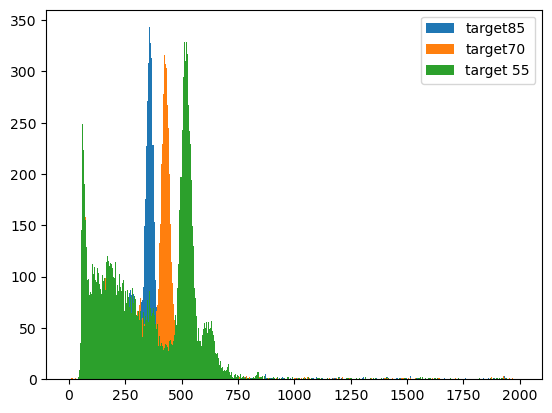

done
done
done
done
done


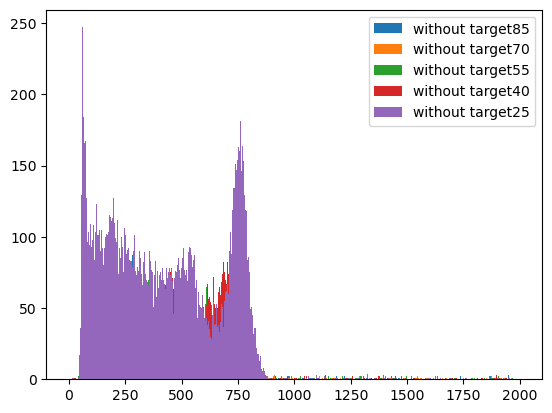

In [26]:
background_files = [x for x in sorted(glob.glob(os.path.join(directory, '*.dat')), key=os.path.getmtime, reverse=True) if ("target" in x ) and ("without" in x)]


target_files = [x for x in sorted(glob.glob(os.path.join(directory, '*.dat')), key=os.path.getmtime, reverse=True) if ("target" in x)and not("without" in x)]
print(background_files)
print(target_files)

target_list = []
background_list = []

for file in target_files:
    file_name=file.split("\\")[-1].split(".")[-2]
    dxList1,tList1,nevent1= dat_extract(directory/file)
    
    n1, bins, patches1 = plt.hist(dxList1, nBins, range=(0,nBins*binSize), label=file_name)
    target_list.append([n1, bins, patches1 ])
plt.legend()

plt.show()

for file in background_files:
    file_name=file.split("\\")[-1].split(".")[-2]
    dxList1,tList1,nevent1= dat_extract(directory/file)
    
    n1, bins, patches1 = plt.hist(dxList1, nBins, range=(0,nBins*binSize), label=file_name)
    background_list.append([n1, bins, patches1 ])

plt.legend()
plt.show()



0.318+/-0.006 0.069+/-0.005
0.369+/-0.006 0.070+/-0.005
0.436+/-0.006 0.039+/-0.005


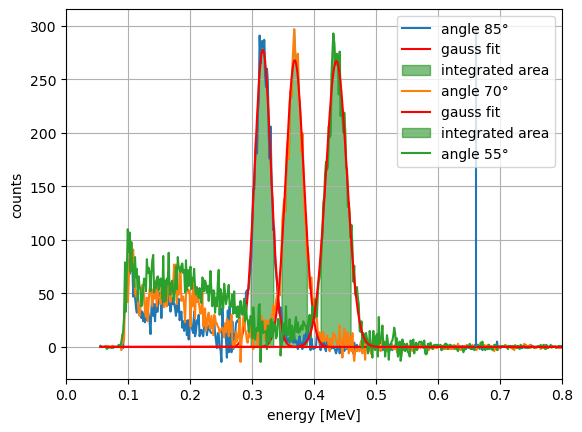

In [36]:

energy_list=[]
event_list=[]

labellist=[85,70,55,40,25]
fit_list=[[300, 400 ], [400, 500 ], [500, 700 ], [500, 700 ], [500, 700 ],]
for i in range(0,len(target_list)):
    plt.plot(convertChannel((target_list[i][1])[:-1]),  (target_list[i][0]-background_list[i][0]), label="angle "+str(labellist[i])+"°" )
    plt.legend()
    bin_centers,n1=(target_list[i][1])[:-1],  (target_list[i][0]-background_list[i][0]),
    x,y,z=gauss_fit(bin_centers,n1, fit_list[i][0], fit_list[i][1], func=convertChannel)
    energy=u.ufloat(convertChannel(x,True).n,convertChannel(x,True).s+convertChannel(y))
    energy_list.append(energy)
    print(convertChannel(x,True),convertChannel(y,True))
    peak=integrate(bin_centers,n1,x,y,z,func=convertChannel)
    event_list.append(peak)
plt.grid(1)
plt.xlim(0,0.8)
plt.xlabel("energy [MeV]")
plt.vlines(0.662,0,300)
plt.ylabel("counts")

plt.show()




$\frac{d\phi}{d\Omega}=\frac{R(\Delta \Omega)}{\Delta \Omega}\cdot \frac{1}{\phi_0 n}\frac{1}{\epsilon}$

$n= \frac{N_A}{A}Z \rho \pi \left ( \frac{d}{2} \right)^2 l$

$\frac{1}{E'} = \frac{1}{E}-\frac{1}{m_0 c^2}(1-cos(\theta))$

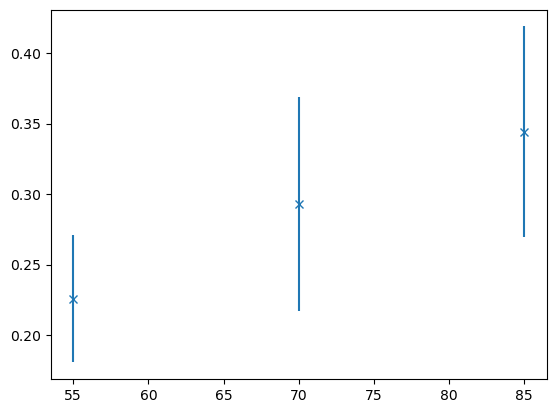

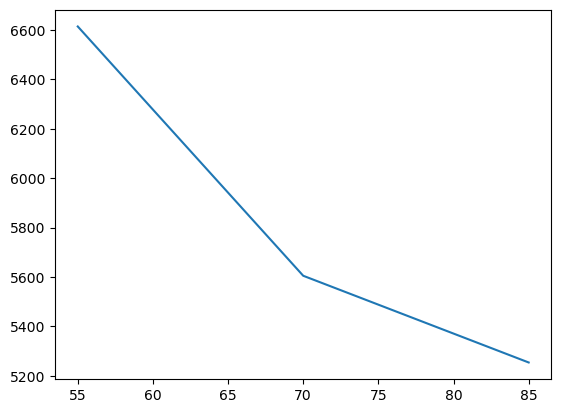

In [ ]:
def n(A, Z, rho, d, l):
    N_a = 1
    return N_a*Z*np.pi*rho*l*(d/2)**2/A
def diff_cross_section(R, DO, phi, n, epsilon):
    return R/(DO*phi*n*epsilon)


plt.errorbar(labellist[:3],[0.662 -x.n for x in energy_list], [x.s for x in energy_list], fmt="x")

plt.show()

plt.plot(labellist[:3],event_list)

plt.show()

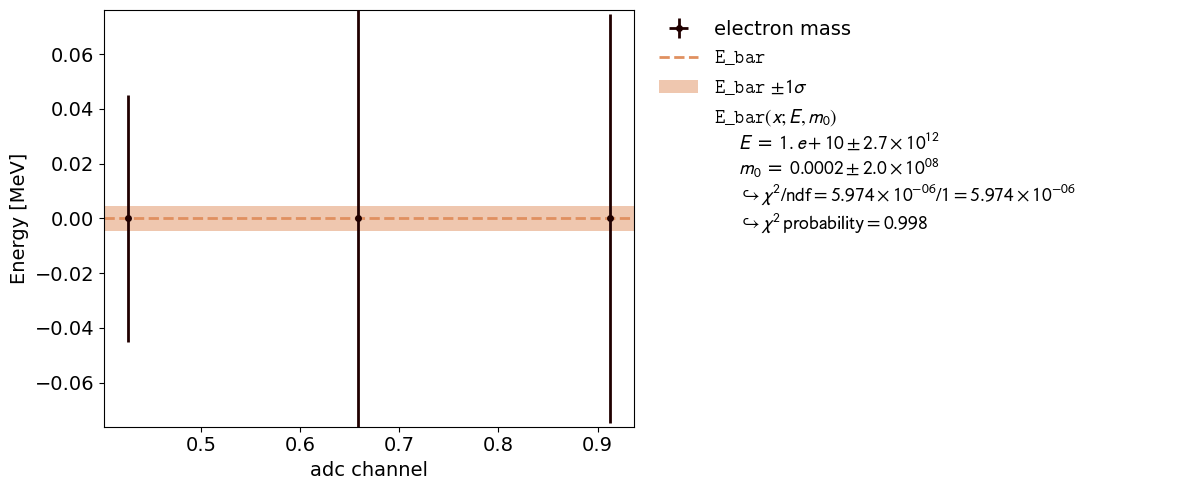

In [ ]:

def E_bar(x,E,m_0=1e-10):
    c = 299792458
    return (1/E*1e6)-x/(m_0*c**2)


data = kafe2.XYContainer((1-np.cos(np.array(labellist[:3])*np.pi/180 )),[1/(x.n*1e6) for x in energy_list])
data.label = 'electron mass'
data.add_error('y', [x.s for x in energy_list])

fit = kafe2.Fit(data,E_bar)
#fit.add_parameter_constraint("E",0.662,0.001)
fit.do_fit()wer
pl = kafe2.Plot(fit)
pl.x_label = 'adc channel'
pl.y_label = 'Energy [MeV]' 
#pl.x_range = (0.0014, 0.0019)

pl.plot()
plt.show()
